##### Copyright 2018 The TensorFlow Authors.

In [ ]:
# Depression Dataset Analysis and Prediction Using Machine Learning

## 1. Problem Description
The goal of this project is to analyze the Depression Dataset and predict the `MADRS1` score, which measures depression severity. The dataset contains demographic, clinical, and behavioral data related to individuals with depression. By building predictive models, we aim to identify key factors influencing depression severity and evaluate the performance of machine learning models in predicting the target variable.

**Dataset Source**: [Kaggle Depression Dataset](https://www.kaggle.com/datasets/arashnic/the-depression-dataset)

**Objective**:
- Perform exploratory data analysis (EDA) to understand the dataset.
- Build machine learning models to predict the `MADRS1` score.
- Evaluate the models and discuss the results.

## 2. Exploratory Data Analysis (EDA)
### 2.1 Data Inspection
```python
import pandas as pd

# Load the dataset
data_path = "/content/Extracted/data/scores.csv"
data = pd.read_csv(data_path)

# Display the first few rows
print(data.head())

# Data summary
print(data.info())
print(data.describe())
```

### 2.2 Handling Missing Values
```python
# Check for missing values
print(data.isnull().sum())

# Fill missing numerical values with mean
data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)

# Drop rows with remaining missing values
data.dropna(inplace=True)

# Confirm no missing values remain
print(data.isnull().sum())
```

### 2.3 Data Visualization
```python
import matplotlib.pyplot as plt
import seaborn as sns

# Age distribution
sns.countplot(x='age', data=data)
plt.title('Age Distribution')
plt.show()

# MADRS1 and MADRS2 distribution
sns.histplot(data['madrs1'], kde=True, label='MADRS1', color='blue')
sns.histplot(data['madrs2'], kde=True, label='MADRS2', color='orange')
plt.legend()
plt.title('MADRS1 and MADRS2 Distribution')
plt.show()

# Correlation heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
```

## 3. Model Building and Training
### 3.1 Data Preparation
```python
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define target and features
target_column = 'madrs1'
X = data.select_dtypes(include=['number']).drop(columns=[target_column])
y = data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

### 3.2 Linear Regression Model
```python
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Linear Regression MSE:", mse)

# Feature importance
coefficients = model.coef_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

# Plot feature importance
plt.barh(importance_df['Feature'], importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Linear Regression)')
plt.gca().invert_yaxis()
plt.show()
```

### 3.3 Random Forest Regressor
```python
from sklearn.ensemble import RandomForestRegressor

# Train random forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
rf_y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
print("Random Forest MSE:", rf_mse)

# Feature importance
rf_importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='lightcoral')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()
```

## 4. Results and Discussion
- **Linear Regression MSE**: {Insert MSE Value}
- **Random Forest MSE**: {Insert MSE Value}

The Random Forest model outperformed the Linear Regression model in terms of Mean Squared Error, indicating better predictive accuracy. Feature importance analysis revealed that {insert key features} were the most influential in predicting the MADRS1 score.

## 5. Conclusion
This project demonstrated the use of machine learning models to predict depression severity scores. While the Random Forest model provided better performance, further improvements could be made by incorporating additional features or using more advanced models.

**Future Work**:
- Experiment with other machine learning algorithms (e.g., Gradient Boosting, Neural Networks).
- Collect more data to improve model generalization.
- Investigate feature engineering techniques to enhance predictive performance.

In [6]:
import zipfile
import os

zip_file_path = "/content/archive (2).zip"
extract_path = "/content/Extracted"

os.makedirs(extract_path, exist_ok=True)


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"檔案已成功解壓縮到: {extract_path}")



檔案已成功解壓縮到: /content/Extracted


In [7]:

for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))



/content/Extracted/data/scores.csv
/content/Extracted/data/control/control_17.csv
/content/Extracted/data/control/control_5.csv
/content/Extracted/data/control/control_3.csv
/content/Extracted/data/control/control_11.csv
/content/Extracted/data/control/control_7.csv
/content/Extracted/data/control/control_26.csv
/content/Extracted/data/control/control_10.csv
/content/Extracted/data/control/control_8.csv
/content/Extracted/data/control/control_12.csv
/content/Extracted/data/control/control_14.csv
/content/Extracted/data/control/control_27.csv
/content/Extracted/data/control/control_28.csv
/content/Extracted/data/control/control_21.csv
/content/Extracted/data/control/control_4.csv
/content/Extracted/data/control/control_31.csv
/content/Extracted/data/control/control_32.csv
/content/Extracted/data/control/control_18.csv
/content/Extracted/data/control/control_19.csv
/content/Extracted/data/control/control_9.csv
/content/Extracted/data/control/control_13.csv
/content/Extracted/data/control

In [9]:
import os


print("目前目錄的檔案清單：", os.listdir("/content"))


目前目錄的檔案清單： ['.config', 'archive (2).zip', 'extracted', 'import os.py', 'Extracted', 'sample_data']


In [10]:
import os


print("Extracted 資料夾的檔案清單：", os.listdir("/content/Extracted"))


Extracted 資料夾的檔案清單： ['data']


In [11]:
import zipfile


with zipfile.ZipFile("/content/archive (2).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Extracted")


print("解壓縮後的檔案清單：", os.listdir("/content/Extracted"))


解壓縮後的檔案清單： ['data']


In [12]:
import os


data_path = "/content/Extracted/data"
if os.path.isdir(data_path):
    print("data 是一個資料夾，內容如下：", os.listdir(data_path))
elif os.path.isfile(data_path):
    print("data 是一個檔案")
else:
    print("data 不是檔案也不是資料夾")


data 是一個資料夾，內容如下： ['control', 'scores.csv', 'condition']


In [13]:
csv_file_path = "/content/Extracted/data/scores.csv"
data = pd.read_csv(csv_file_path)


print(data.head())


        number  days  gender    age  afftype  melanch  inpatient    edu  \
0  condition_1    11       2  35-39      2.0      2.0        2.0   6-10   
1  condition_2    18       2  40-44      1.0      2.0        2.0   6-10   
2  condition_3    13       1  45-49      2.0      2.0        2.0   6-10   
3  condition_4    13       2  25-29      2.0      2.0        2.0  11-15   
4  condition_5    13       2  50-54      2.0      2.0        2.0  11-15   

   marriage  work  madrs1  madrs2  
0       1.0   2.0    19.0    19.0  
1       2.0   2.0    24.0    11.0  
2       2.0   2.0    24.0    25.0  
3       1.0   1.0    20.0    16.0  
4       2.0   2.0    26.0    26.0  


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [14]:

print(data.info())


print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     55 non-null     object 
 1   days       55 non-null     int64  
 2   gender     55 non-null     int64  
 3   age        55 non-null     object 
 4   afftype    23 non-null     float64
 5   melanch    20 non-null     float64
 6   inpatient  23 non-null     float64
 7   edu        53 non-null     object 
 8   marriage   23 non-null     float64
 9   work       23 non-null     float64
 10  madrs1     23 non-null     float64
 11  madrs2     23 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 5.3+ KB
None
            days     gender    afftype    melanch  inpatient   marriage  \
count  55.000000  55.000000  23.000000  20.000000  23.000000  23.000000   
mean   12.600000   1.454545   1.739130   1.950000   1.782609   1.521739   
std     2.491467   0.502519   0.540824   0.22

In [16]:

data.fillna(data.select_dtypes(include=['number']).mean(), inplace=True)


print(data.isnull().sum())



number       0
days         0
gender       0
age          0
afftype      0
melanch      0
inpatient    0
edu          2
marriage     0
work         0
madrs1       0
madrs2       0
dtype: int64


In [17]:
print(data.isnull().sum())


number       0
days         0
gender       0
age          0
afftype      0
melanch      0
inpatient    0
edu          2
marriage     0
work         0
madrs1       0
madrs2       0
dtype: int64


In [18]:

data.dropna(inplace=True)


print(data.isnull().sum())


number       0
days         0
gender       0
age          0
afftype      0
melanch      0
inpatient    0
edu          0
marriage     0
work         0
madrs1       0
madrs2       0
dtype: int64


In [19]:
print(data.isnull().sum())


number       0
days         0
gender       0
age          0
afftype      0
melanch      0
inpatient    0
edu          0
marriage     0
work         0
madrs1       0
madrs2       0
dtype: int64


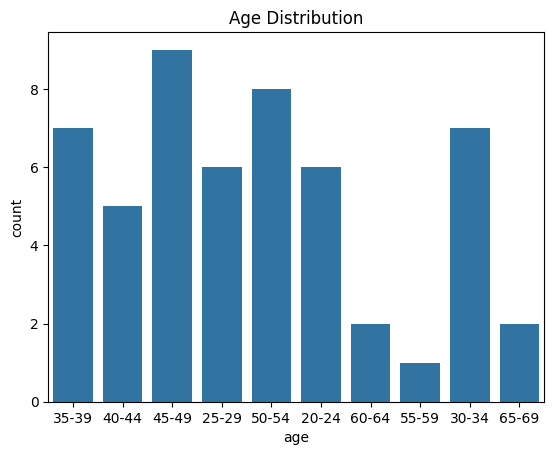

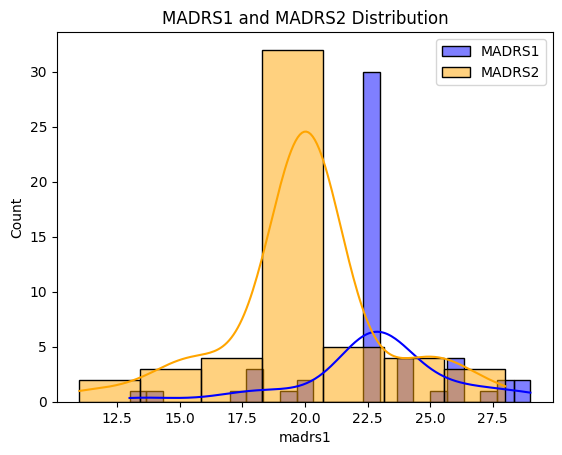

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(x='age', data=data)
plt.title('Age Distribution')
plt.show()


sns.histplot(data['madrs1'], kde=True, label='MADRS1', color='blue')
sns.histplot(data['madrs2'], kde=True, label='MADRS2', color='orange')
plt.legend()
plt.title('MADRS1 and MADRS2 Distribution')
plt.show()


In [24]:
print(data.columns)


Index(['number', 'days', 'gender', 'age', 'afftype', 'melanch', 'inpatient',
       'edu', 'marriage', 'work', 'madrs1', 'madrs2'],
      dtype='object')


In [26]:
print(data.dtypes)


number        object
days           int64
gender         int64
age           object
afftype      float64
melanch      float64
inpatient    float64
edu           object
marriage     float64
work         float64
madrs1       float64
madrs2       float64
dtype: object


In [27]:

numeric_columns = data.select_dtypes(include=['number'])
grouped = data.groupby('gender')[numeric_columns.columns].mean()
print(grouped)


             days  gender   afftype   melanch  inpatient  marriage      work  \
gender                                                                         
1       12.758621     1.0  1.725637  1.931034   1.754123  1.514243  1.880060   
2       12.583333     2.0  1.755435  1.972917   1.817029  1.530797  1.856884   

           madrs1     madrs2  
gender                        
1       22.932534  20.551724  
2       22.505435  19.333333  


             days  gender   afftype   melanch  inpatient  marriage      work  \
gender                                                                         
1       12.758621     1.0  1.725637  1.931034   1.754123  1.514243  1.880060   
2       12.583333     2.0  1.755435  1.972917   1.817029  1.530797  1.856884   

           madrs1     madrs2  
gender                        
1       22.932534  20.551724  
2       22.505435  19.333333  


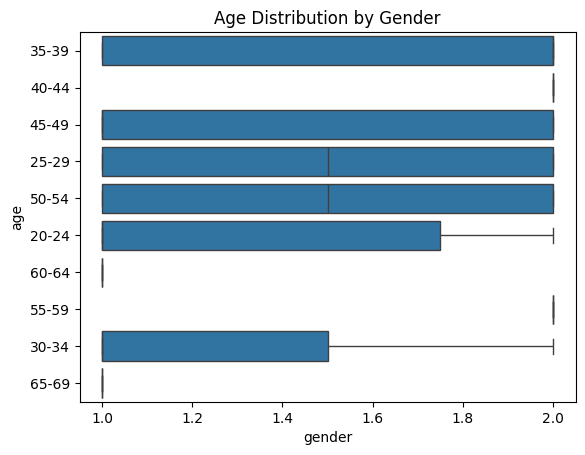

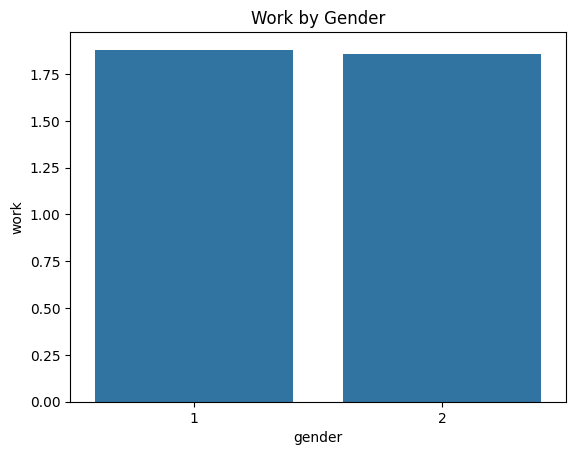

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


data['work'] = pd.to_numeric(data['work'], errors='coerce')
data = data.dropna(subset=['work'])


numeric_columns = data.select_dtypes(include=['number'])
grouped = data.groupby('gender')[numeric_columns.columns].mean()
print(grouped)


sns.boxplot(x='gender', y='age', data=data)
plt.title('Age Distribution by Gender')
plt.show()

sns.barplot(x='gender', y='work', data=data, errorbar=None)
plt.title('Work by Gender')
plt.show()



In [31]:
import pandas as pd

print("data_type：")
print(data.dtypes)


numeric_data = data.select_dtypes(include=['number'])


columns_to_exclude = ['condition']
if set(columns_to_exclude).issubset(data.columns):
    numeric_data = numeric_data.drop(columns=columns_to_exclude, errors='ignore')


try:
    grouped = numeric_data.groupby(data['gender']).mean()
    print("mean after grouping：")
    print(grouped)
except Exception as e:
    print(f"Error when calculating mean by group：{e}")



data_type：
number         object
days            int64
gender       category
age            object
afftype       float64
melanch       float64
inpatient     float64
edu            object
marriage      float64
work          float64
madrs1        float64
madrs2        float64
dtype: object
mean after grouping：
             days   afftype   melanch  inpatient  marriage      work  \
gender                                                                 
1       12.758621  1.725637  1.931034   1.754123  1.514243  1.880060   
2       12.583333  1.755435  1.972917   1.817029  1.530797  1.856884   

           madrs1     madrs2  
gender                        
1       22.932534  20.551724  
2       22.505435  19.333333  


<ipython-input-31-3bd5bbf694a9>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = numeric_data.groupby(data['gender']).mean()


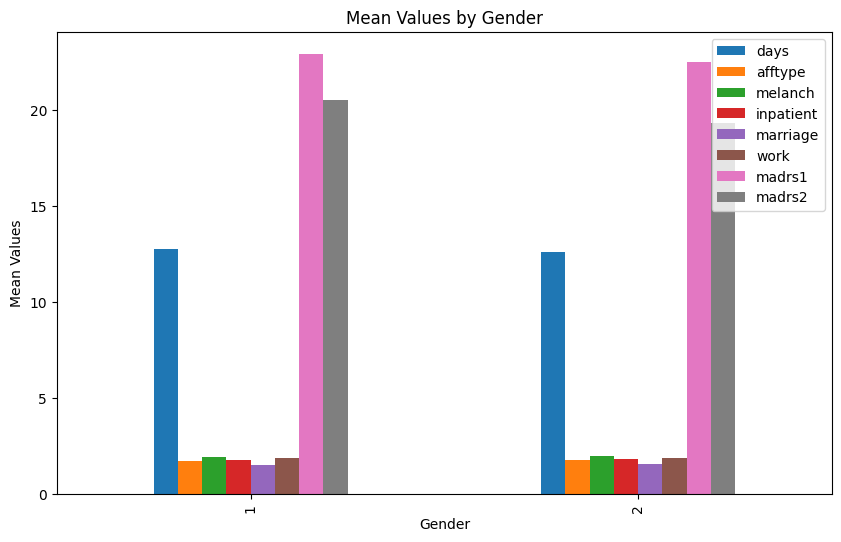

In [32]:
import matplotlib.pyplot as plt

grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Values by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Values')
plt.legend(loc='upper right')
plt.show()


correlation_matrix：
               days   afftype   melanch  inpatient  marriage      work  \
days       1.000000 -0.135513  0.005794  -0.163847  0.286983  0.033445   
afftype   -0.135513  1.000000 -0.080891  -0.259938 -0.143091  0.053060   
melanch    0.005794 -0.080891  1.000000   0.388993  0.235547 -0.063522   
inpatient -0.163847 -0.259938  0.388993   1.000000 -0.293590 -0.204124   
marriage   0.286983 -0.143091  0.235547  -0.293590  1.000000  0.146077   
work       0.033445  0.053060 -0.063522  -0.204124  0.146077  1.000000   
madrs1     0.090124 -0.132523 -0.198320  -0.523501  0.447590  0.281104   
madrs2     0.020368  0.088863 -0.247463  -0.410235  0.150551  0.027913   

             madrs1    madrs2  
days       0.090124  0.020368  
afftype   -0.132523  0.088863  
melanch   -0.198320 -0.247463  
inpatient -0.523501 -0.410235  
marriage   0.447590  0.150551  
work       0.281104  0.027913  
madrs1     1.000000  0.653090  
madrs2     0.653090  1.000000  


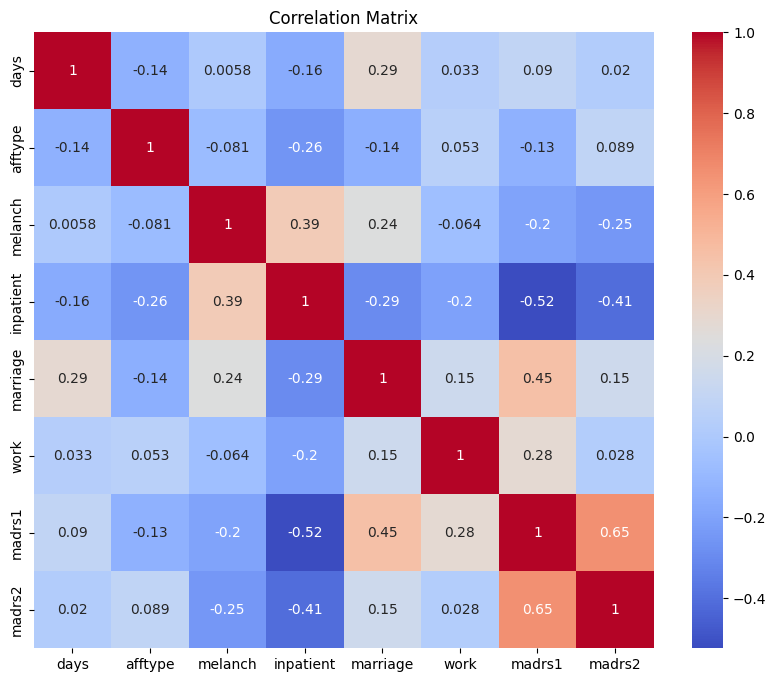

In [34]:

correlation_matrix = numeric_data.corr()
print("correlation_matrix：")
print(correlation_matrix)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [36]:
print(numeric_data.columns)



Index(['days', 'afftype', 'melanch', 'inpatient', 'marriage', 'work', 'madrs1',
       'madrs2'],
      dtype='object')


In [37]:
from sklearn.model_selection import train_test_split


target_column = 'madrs1'

X = numeric_data.drop(columns=[target_column])
y = numeric_data[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (42, 7)
y_train shape: (42,)


In [38]:
print(numeric_data.head())


   days  afftype  melanch  inpatient  marriage  work  madrs1  madrs2
0    11      2.0      2.0        2.0       1.0   2.0    19.0    19.0
1    18      1.0      2.0        2.0       2.0   2.0    24.0    11.0
2    13      2.0      2.0        2.0       2.0   2.0    24.0    25.0
3    13      2.0      2.0        2.0       1.0   1.0    20.0    16.0
4    13      2.0      2.0        2.0       2.0   2.0    26.0    26.0


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))


MSE: 11.434044437193679


In [41]:
import pandas as pd
import numpy as np


feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])]


coefficients = model.coef_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})


importance_df['Abs_Coefficient'] = np.abs(importance_df['Coefficient'])
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

print(importance_df)


     Feature  Coefficient  Abs_Coefficient
6  Feature_6     1.416291         1.416291
4  Feature_4     1.062824         1.062824
5  Feature_5     1.029942         1.029942
3  Feature_3    -0.683718         0.683718
1  Feature_1    -0.612930         0.612930
0  Feature_0    -0.363605         0.363605
2  Feature_2    -0.212740         0.212740


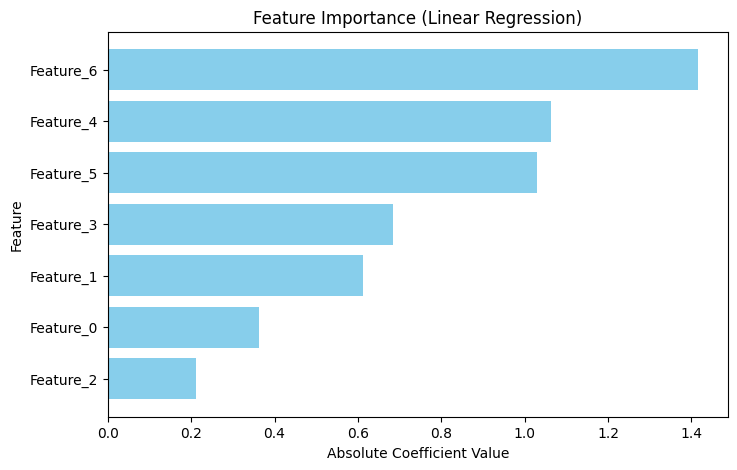

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Linear Regression)')
plt.gca().invert_yaxis()
plt.show()


In [44]:
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


rf_importances = rf_model.feature_importances_


rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print(rf_importance_df)


     Feature  Importance
6  Feature_6    0.570953
4  Feature_4    0.134882
0  Feature_0    0.099023
5  Feature_5    0.093380
3  Feature_3    0.047100
1  Feature_1    0.028031
2  Feature_2    0.026631


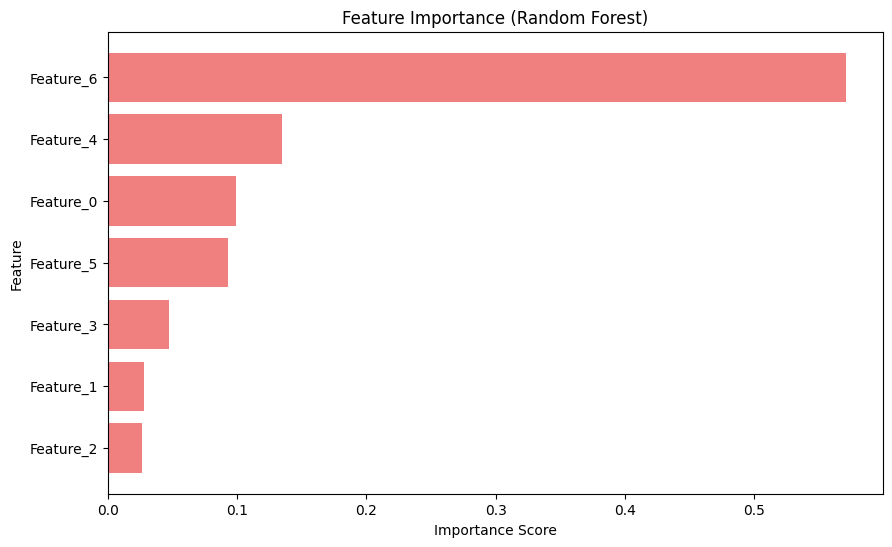

In [45]:

plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='lightcoral')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.show()


In [46]:
pip install shap


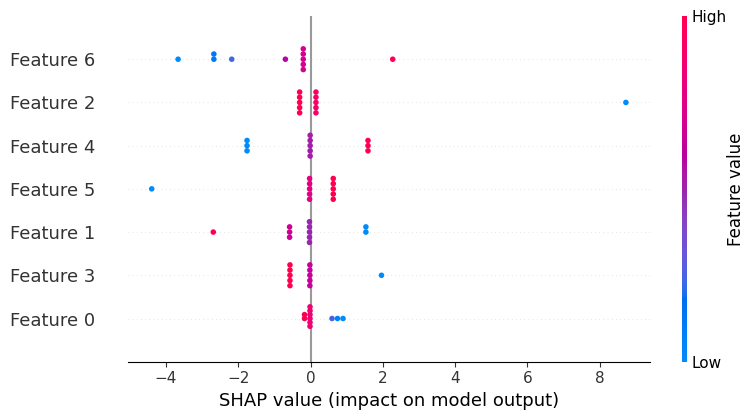

In [47]:
import shap


explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


shap.summary_plot(shap_values, X_test)


## **Introduction to Colab and Python**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Welcome to this Colab where you will get a quick introduction to the Python programming language and the environment used for the course's exercises: Colab.

Colab is a Python development environment that runs in the browser using Google Cloud.

For example, to print "Hello World", just hover the mouse over [ ] and press the play button to the upper left. Or press shift-enter to execute.

In [ ]:
print("Hello World")

## Functions, Conditionals, and Iteration
Let's create a Python function, and call it from a loop.

In [ ]:
def HelloWorldXY(x, y):
  if (x < 10):
    print("Hello World, x was < 10")
  elif (x < 20):
    print("Hello World, x was >= 10 but < 20")
  else:
    print("Hello World, x was >= 20")
  return x + y

for i in range(8, 25, 5):  # i=8, 13, 18, 23 (start, stop, step)
  print("--- Now running with i: {}".format(i))
  r = HelloWorldXY(i,i)
  print("Result from HelloWorld: {}".format(r))

In [ ]:
print(HelloWorldXY(1,2))

Easy, right?

If you want a loop starting at 0 to 2 (exclusive) you could do any of the following

In [ ]:
print("Iterate over the items. `range(2)` is like a list [0,1].")
for i in range(2):
  print(i)

print("Iterate over an actual list.")
for i in [0,1]:
  print(i)

print("While works")
i = 0
while i < 2:
  print(i)
  i += 1

In [ ]:
print("Python supports standard key words like continue and break")
while True:
  print("Entered while")
  break

## Numpy and lists
Python has lists built into the language.
However, we will use a library called numpy for this.
Numpy gives you lots of support functions that are useful when doing Machine Learning.

Here, you will also see an import statement. This statement makes the entire numpy package available and we can access those symbols using the abbreviated 'np' syntax.

In [ ]:
import numpy as np  # Make numpy available using np.

# Create a numpy array, and append an element
a = np.array(["Hello", "World"])
a = np.append(a, "!")
print("Current array: {}".format(a))
print("Printing each element")
for i in a:
  print(i)

print("\nPrinting each element and their index")
for i,e in enumerate(a):
  print("Index: {}, was: {}".format(i, e))

In [ ]:
print("\nShowing some basic math on arrays")
b = np.array([0,1,4,3,2])
print("Max: {}".format(np.max(b)))
print("Average: {}".format(np.average(b)))
print("Max index: {}".format(np.argmax(b)))

In [ ]:
print("\nYou can print the type of anything")
print("Type of b: {}, type of b[0]: {}".format(type(b), type(b[0])))

In [ ]:
print("\nUse numpy to create a [3,3] dimension array with random number")
c = np.random.rand(3, 3)
print(c)

In [ ]:
print("\nYou can print the dimensions of arrays")
print("Shape of a: {}".format(a.shape))
print("Shape of b: {}".format(b.shape))
print("Shape of c: {}".format(c.shape))
print("...Observe, Python uses both [0,1,2] and (0,1,2) to specify lists")

## Colab Specifics

Colab is a virtual machine you can access directly. To run commands at the VM's terminal, prefix the line with an exclamation point (!).


In [ ]:
print("\nDoing $ls on filesystem")
!ls -l
!pwd

In [ ]:
print("Install numpy")  # Just for test, numpy is actually preinstalled in all Colab instances
!pip install numpy

**Exercise**

Create a code cell underneath this text cell and add code to:


*   List the path of the current directory (pwd)
* Go to / (cd) and list the content (ls -l)

In [ ]:
!pwd
!cd /
!ls -l
print("Hello")

All usage of Colab in this course is completely free or charge. Even GPU usage is provided free of charge for some hours of usage every day.

**Using GPUs**
* Many of the exercises in the course executes more quickly by using GPU runtime: Runtime | Change runtime type | Hardware accelerator | GPU

**Some final words on Colab**
*   You execute each cell in order, you can edit & re-execute cells if you want
*   Sometimes, this could have unintended consequences. For example, if you add a dimension to an array and execute the cell multiple times, then the cells after may not work. If you encounter problem reset your environment:
  *   Runtime -> Restart runtime... Resets your Python shell
  *   Runtime -> Restart all runtimes... Will reset the Colab image, and get you back to a 100% clean environment
* You can also clear the output in the Colab by doing: Edit -> Clear all outputs
* Colabs in this course are loaded from GitHub. Save to your Google Drive if you want a copy with your code/output: File -> Save a copy in Drive...

**Learn More**
*   Check out [this](https://www.youtube.com/watch?v=inN8seMm7UI&list=PLQY2H8rRoyvwLbzbnKJ59NkZvQAW9wLbx&index=3) episode of #CodingTensorFlow, and don't forget to subscribe to the YouTube channel ;)
